In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sympy import *

# Here we will compute the Lyapunov exponent for our one-dimensional map

# define the a cubic toy model \psi_\theta
def phasemap(a, b, c, x):
    return a*x**3 + b*x**2 + c*x

# define the inverse of above cubic toy model \psi_\-theta
def invphasemap(a, b, c, x):
    if x>=0 and x<np.pi:
        return phasemap(a, b, c, x+np.pi) - np.pi
    if x>=np.pi and x<2*np.pi:
        return phasemap(a, b, c, x-np.pi) + np.pi

# set coefficients
a = 17/(6*np.pi**2)
b = -33/(4*np.pi)
c = 37/6

# derivative
x = Symbol('x')
f = phasemap(a, b, c, x)
f_prime = f.diff(x)
f_prime = lambdify(x, f_prime)

# Lyapunov exponent
phis = np.linspace(0, 2*np.pi, num=100000)
lyap = sum(np.log(abs(f_prime(phis))))*(1/len(phis))
print("The Lyapunov exponent is " + str(lyap) + ".")

The Lyapunov exponent is 0.36633012564163236.


In [3]:
# create initial orientations drawn randomly from a concentrated interval

import random

random.seed(0)

# width of the interval
width = 2*np.pi/100000

# randomly pick a starting position
left = random.uniform(0,2*np.pi)
right = left + width

# draw n values from the interval
def draw_n(n):
    initial = [0]*n
    for i in range(n):
        initial[i] = random.uniform(left, right)
    return np.array(initial)

In [4]:
# send the set of orientations through the phase map
#    and waiting through the transient

def mapping(orientations, counter):
    if counter == 0:
        tilted = [phasemap(a, b, c, x) for x in orientations]
    elif counter == 1:
        tilted = [invphasemap(a, b, c, x) for x in orientations]
    else:
        tilted = nan
    return np.array(tilted)

def translation(orientations, omega):
    timestep = random.uniform(0, 2*np.pi/omega)
    pasttransient = orientations + omega*timestep
    return pasttransient

# a mapping (to psi) followed by a translation (to tilde phi)
#    gives a second set of orientations ready to undergo another
#    tilt in the external forcing

def iteration(orientations, counter, omega):
    final = translation(mapping(orientations, counter), omega)
    final = [np.mod(final[i], 2*np.pi) for i in range(len(final))]
    return np.array(final)

In [6]:
# nearest neighbor estimate of information theoretic entropy

def closest(i, j, k):
    if j-i == 0 or k-j == 0:
        return 1e-30
    elif j-i <= k-j:
        return j-i
    else:
        return k-j

def sumterm(orientations):
    sort = np.sort(orientations)
    acc = 0
    for n in range(len(orientations)):
        if n == 0:
            acc = acc + np.log(sort[1] - sort[0])
        elif n == len(orientations) - 1:
            acc = acc + np.log(sort[-1] - sort[-2])
        else:
            acc = acc + np.log(closest(sort[n-1], sort[n], sort[n+1]))
    return acc

def entropy(orientations):
    m = len(orientations)
    euler = 0.57721566
    infoentropy = sumterm(orientations)/m + np.log(2*m-2) + euler
    return infoentropy

In [7]:
# set the number of objects to work with
numbodies = 300
initial = draw_n(numbodies)

# evolves a system of n objects m times, and records the entropy at each step
#    for example: evolution(initial,1000) gives the entropy for a sequence of 1000
#    randomly timed tilts for 300 bodies
def evolution(orientations, ntimes):
    entropylist = []
    for i in range(ntimes+1):
        if np.mod(i,2) == 0:
            orientations = iteration(orientations, 0, 0.5)
        else:
            orientations = iteration(orientations, 1, 0.5)
        entropylist.append(entropy(orientations))
    del entropylist[0]
    return entropylist

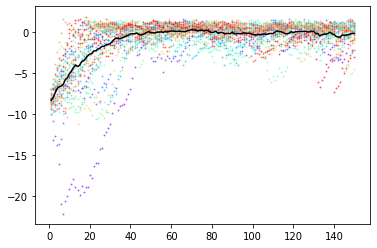

In [8]:
import matplotlib.cm as cm

# set the number of iterations to evolve the system
iterations = 150

# create x values (iteration number) and y values (entropy over iterations)
x = np.linspace(1, iterations, num=iterations)
ys = [evolution(initial, iterations) for i in range(30)] 

# compute the average entropy at each iteration
average = [np.mean([ys[j][i] for j in range(30)]) for i in range(iterations)]

# create color map for each evolution sequence
colors = cm.rainbow(np.linspace(0, 1, num=len(ys)))

for y, col in zip(ys, colors):
    plt.scatter(x, y, s=1, color=col, alpha=0.5)
plt.plot(x, average, c='black')
plt.show()